<a href="https://colab.research.google.com/github/Mariam-Zaidi/Melanoma-Detection-using-CNN/blob/main/Assignment_CNN_Skin_Cancer_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from matplotlib import style
plt.style.use('seaborn-notebook')

<ipython-input-1-17c5e2dd6f4b>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')
<ipython-input-11-17c5e2dd6f4b>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_path = 'gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration' 


Mounted at /content/gdrive
Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118
2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir_train,
                                                               validation_split = 0.2, 
                                                               subset= "training", 
                                                               seed = 123, 
                                                               image_size=(img_height, img_width),
                                                               batch_size = batch_size )
  

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir_train,
                                                               validation_split = 0.2, 
                                                               subset= "validation", 
                                                               seed = 123, 
                                                               image_size=(img_height, img_width),
                                                               batch_size = batch_size )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

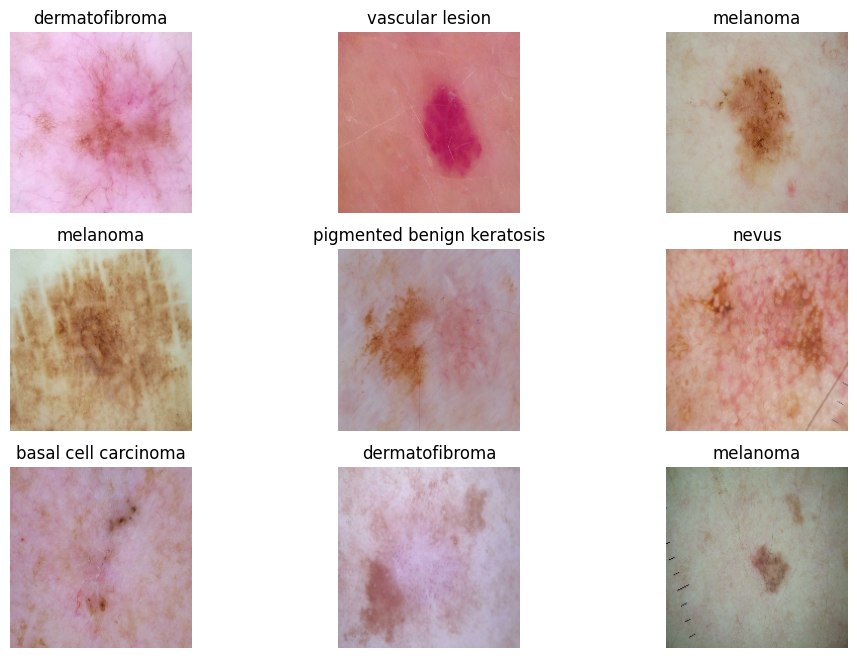

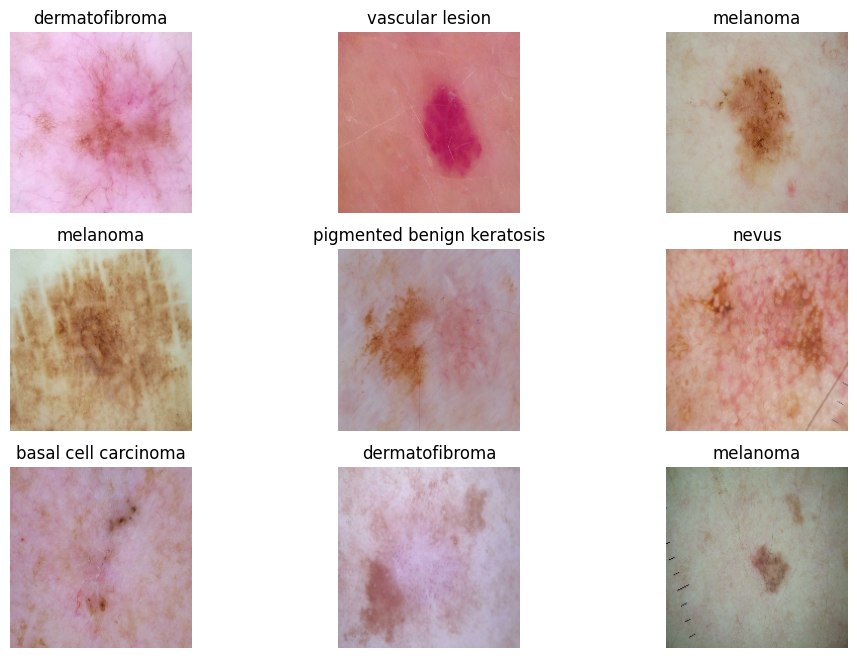

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

num_classes = 9

plt.figure(figsize = (12,8))
for images, labels in train_ds.take(1):
  for i in range(num_classes):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)
(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

## Define the model
The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 180 units on top of it that is activated by a ReLU activation function ('relu').

In [ ]:
input_shape = (180,180,3)


model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding = "same", input_shape=(180, 180, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu',  padding = "same"))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu',  padding = "same"))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Compile the model
We use the tf.keras.optimizers.Adam optimizer(Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments) and tf.keras.losses.SparseCategoricalCrossentropy loss function (when there are two or more label classes). To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.Model.compile() configures the model for training.

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [ ]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 214s 3s/step - loss: 2.2008 - accuracy: 0.2165 - val_loss: 1.8661 - val_accuracy: 0.3043
Epoch 2/20
56/56 [==============================] - 188s 3s/step - loss: 1.7633 - accuracy: 0.3449 - val_loss: 1.6258 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 179s 3s/step - loss: 1.6126 - accuracy: 0.4252 - val_loss: 1.5200 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 180s 3s/step - loss: 1.4133 - accuracy: 0.5078 - val_loss: 1.6557 - val_accuracy: 0.4407
Epoch 5/20
56/56 [==============================] - 186s 3s/step - loss: 1.3605 - accuracy: 0.5089 - val_loss: 1.4359 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 189s 3s/step - loss: 1.2442 - accuracy: 0.5564 - val_loss: 1.3900 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 177s 3s/step - loss: 1.1626 - accuracy: 0.5876 - val_loss: 1.4128 - val_accuracy: 0.5034
Epoch 8/20
56/56 [======

### Visualizing training results

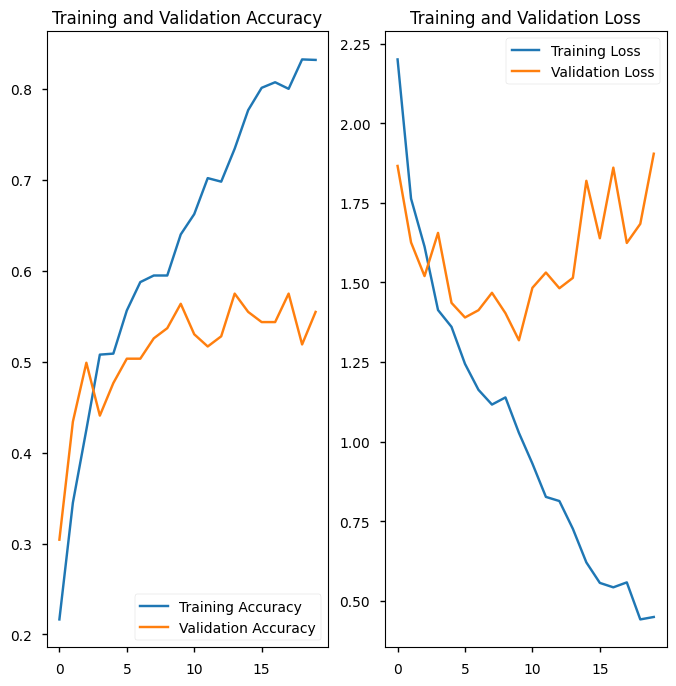

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 9s 599ms/step - loss: 1.9045 - accuracy: 0.5548
Accuracy:  0.89453125
Validation Accuracy:  0.5548098683357239
Loss:  0.282347708940506
Validation Loss 1.9045308828353882


### Write your findings here

The model is overfitting because we see that the accuracy on Train data is high but on Validation data it doesnt improve after 5 epochs. We can also see difference in loss functions in training & validation data.
Hence the model is Overfit and we need to chose right data augumentation strategy.

**Data augmentation** is a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation.

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')])

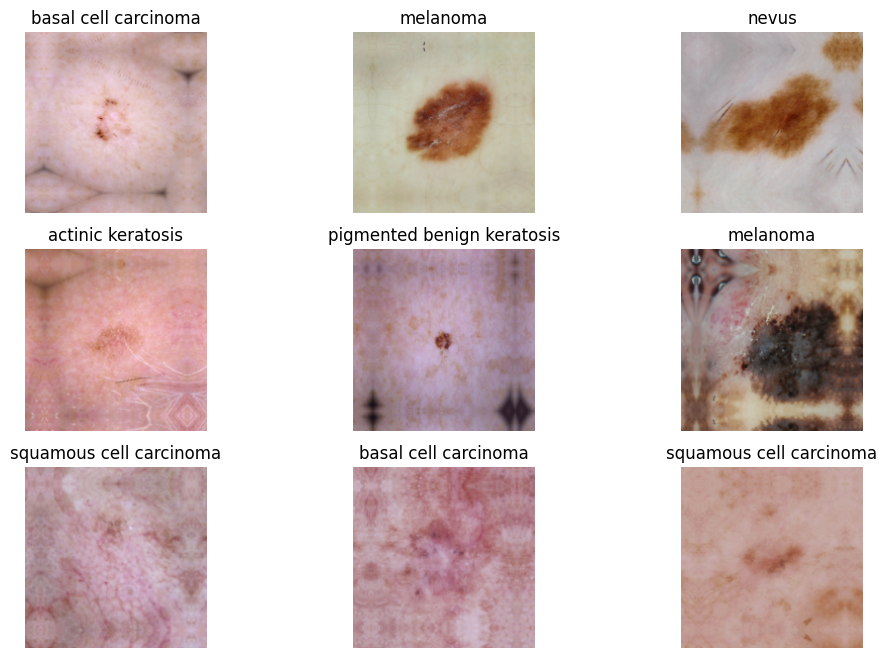

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


Dropout
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When we apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here

num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3))
      
])

model.add(Conv2D(32, (3, 3), activation='relu', padding = "same", input_shape=(180, 180, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',  padding = "same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu',  padding = "same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 207s 4s/step - loss: 3.1125 - accuracy: 0.1819 - val_loss: 2.0986 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 196s 4s/step - loss: 2.0408 - accuracy: 0.1942 - val_loss: 2.0544 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 198s 4s/step - loss: 1.9787 - accuracy: 0.2316 - val_loss: 1.9095 - val_accuracy: 0.3535
Epoch 4/20
56/56 [==============================] - 197s 4s/step - loss: 1.9270 - accuracy: 0.2863 - val_loss: 1.8859 - val_accuracy: 0.3087
Epoch 5/20
56/56 [==============================] - 210s 4s/step - loss: 1.8236 - accuracy: 0.3326 - val_loss: 1.7685 - val_accuracy: 0.3579
Epoch 6/20
56/56 [==============================] - 207s 4s/step - loss: 1.7214 - accuracy: 0.3839 - val_loss: 1.6774 - val_accuracy: 0.4072
Epoch 7/20
56/56 [==============================] - 198s 4s/step - loss: 1.6530 - accuracy: 0.4018 - val_loss: 1.6046 - val_accuracy: 0.4430
Epoch 8/20
56

### Visualizing the results

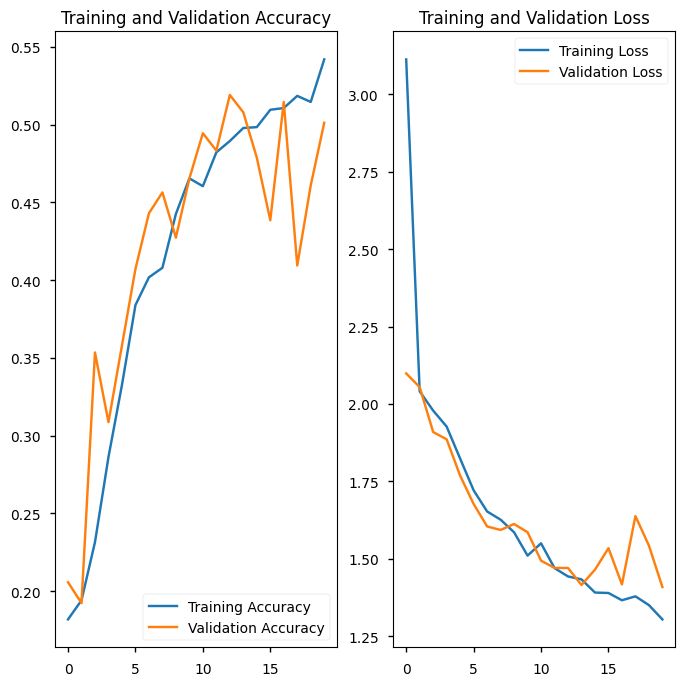

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 10s 729ms/step - loss: 1.4090 - accuracy: 0.5011
Accuracy:  0.5055803656578064
Validation Accuracy:  0.501118540763855
Loss:  1.3200187683105469
Validation Loss 1.409010410308838


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

path_list=[]
lesion_list=[]

for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df


,Path,Label
0,gdrive/My Drive/Colab Notebooks/Skin cancer IS...,actinic keratosis
1,gdrive/My Drive/Colab Notebooks/Skin cancer IS...,actinic keratosis
2,gdrive/My Drive/Colab Notebooks/Skin cancer IS...,actinic keratosis
3,gdrive/My Drive/Colab Notebooks/Skin cancer IS...,actinic keratosis
4,gdrive/My Drive/Colab Notebooks/Skin cancer IS...,actinic keratosis
...,...,...
2234,gdrive/My Drive/Colab Notebooks/Skin cancer IS...,vascular lesion
2235,gdrive/My Drive/Colab Notebooks/Skin cancer IS...,vascular lesion
2236,gdrive/My Drive/Colab Notebooks/Skin cancer IS...,vascular lesion
2237,gdrive/My Drive/Colab Notebooks/Skin cancer IS...,vascular lesion


<BarContainer object of 9 artists>

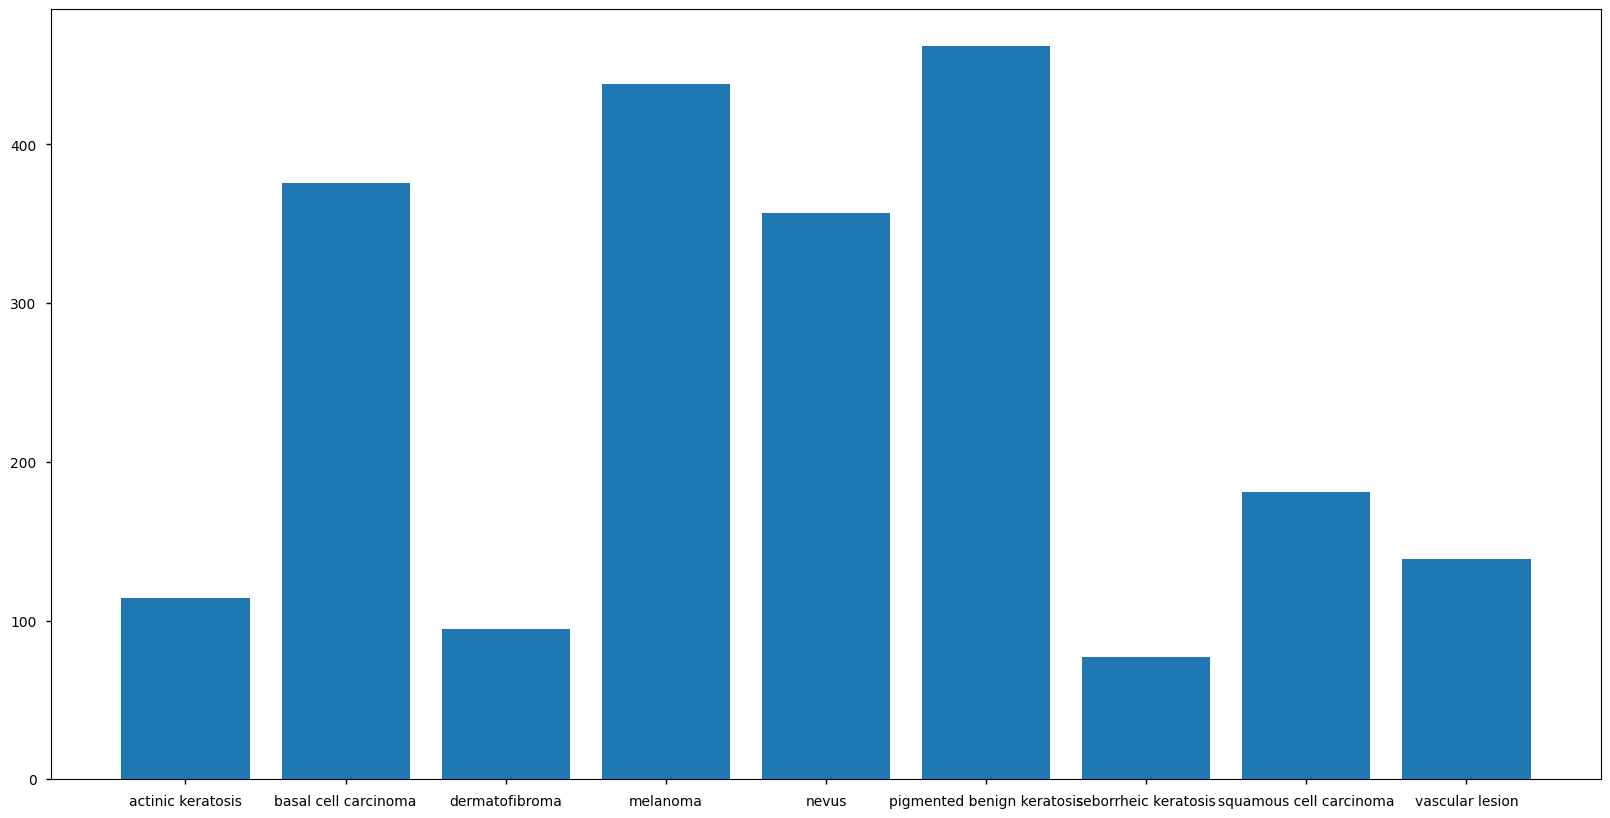

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(20,10))
plt.bar(class_names,count)

In [ ]:
original_df[['Label']].value_counts(normalize=True)

Label                     
pigmented benign keratosis    0.206342
melanoma                      0.195623
basal cell carcinoma          0.167932
nevus                         0.159446
squamous cell carcinoma       0.080840
vascular lesion               0.062081
actinic keratosis             0.050916
dermatofibroma                0.042430
seborrheic keratosis          0.034390
dtype: float64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

Seborrheic keratosis has least number of samples

#### - Which classes dominate the data in terms proportionate number of samples?

Actinic keratosis and dermatofibroma have proportionate number of classes. Melanoma and Pigmented benign keratosis have proprtionate number of classes

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
  p = Augmentor.Pipeline(path_to_training_dataset + i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC67A99C610>: 100%|██████████| 500/500 [00:27<00:00, 18.26 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC67AC606A0>: 100%|██████████| 500/500 [00:29<00:00, 17.00 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC67ACD8F70>: 100%|██████████| 500/500 [00:33<00:00, 14.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2597x2185 at 0x7FC67A9B65B0>: 100%|██████████| 500/500 [02:04<00:00,  4.03 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FC67A928700>: 100%|██████████| 500/500 [02:13<00:00,  3.76 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC67A930100>: 100%|██████████| 500/500 [00:28<00:00, 17.68 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC67A9899A0>: 100%|██████████| 500/500 [01:02<00:00,  8.00 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC60C38BEE0>: 100%|██████████| 500/500 [00:26<00:00, 19.05 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC67AA25400>: 100%|██████████| 500/500 [00:28<00:00, 17.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

5000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
import os
data_dir_train = "/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, "*","output", "*.jpg"))]
path_list_new[:2]

['/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025781.jpg_ab9e39b2-2f4a-4a9c-96bf-b056c8d30157.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026744.jpg_abe00d6e-a125-4984-b33f-4f16a910aae8.jpg']

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new [:2]

['pigmented benign keratosis', 'pigmented benign keratosis']

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-33-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [ ]:
new_df['Label'].value_counts()

actinic keratosis             1114
pigmented benign keratosis     962
melanoma                       938
basal cell carcinoma           876
nevus                          857
squamous cell carcinoma        681
vascular lesion                639
dermatofibroma                 595
seborrheic keratosis           577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7239 files belonging to 9 classes.
Using 5792 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7239 files belonging to 9 classes.
Using 1447 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(32, (3, 3), activation='relu', padding = "same", input_shape=(180, 180, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',  padding = "same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu',  padding = "same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:

## Your code goes here, use 50 epochs.
epochs =30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
181/181 [==============================] - 631s 3s/step - loss: 2.2656 - accuracy: 0.1573 - val_loss: 2.0818 - val_accuracy: 0.2744
Epoch 2/30
  3/181 [..............................] - ETA: 8:02 - loss: 2.0405 - accuracy: 0.2083

KeyboardInterrupt: ignored

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Accuracy on training data and validation data has increased after using Augmentor library.
But we can see that the training accuracy is still much more than validation accuracy hence the model is still overfitting.
The model can be further improved by tuning the hyperparameters.
